## Imports

In [1]:
from subpred.transporter_dataset import create_dataset, get_clustering_stats
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    get_clusters,
    corr_heatmap,
    pca_plot_2d,
    pca_plot_3d,
    perform_pca,
    feature_importance_plot,
)
from subpred.cdhit import cd_hit

In [2]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "keep",
    outliers=["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"],
    verbose = True,
    tax_ids_filter = [3702],
    output_log = "../logs/athaliana_amino_sugar_dataset.log",
    # sequence_clustering = 70
)
df.columns

Index(['keywords_transport', 'keywords_location', 'keywords_transport_related',
       'gene_names', 'protein_names', 'tcdb_id', 'tcdb_class', 'organism_id',
       'sequence'],
      dtype='object')

<AxesSubplot:xlabel='identity_threshold', ylabel='count'>

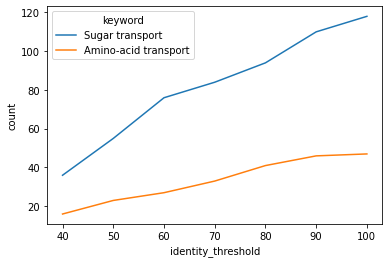

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

df_stats_long = get_clustering_stats(df)

sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_transport"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)

{'Sugar transport': 1, 'Amino-acid transport': 0}


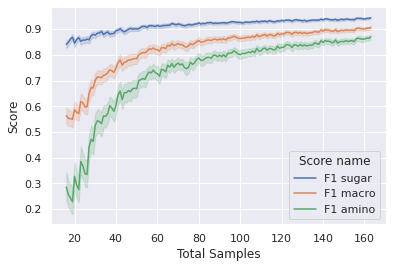

In [9]:
# TODO turn into function, generalize

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from joblib import Parallel, delayed

from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

def test_case(df_features, labels, n_samples, random_seed, score):
    df_features_sampled, _, labels_sampled, _ = train_test_split(
        df_features,
        labels,
        stratify=labels,
        random_state=random_seed,
        train_size=n_samples,
        shuffle=True,
    )

    X = df_features_sampled.to_numpy()
    y = label_encoder.transform(labels_sampled)

    estimator = make_pipeline(
        StandardScaler(), SVC(class_weight="balanced")
    )

    cv_results = cross_val_score(estimator, X, y, n_jobs=1, scoring=score[1])
    records = []
    for cv_result in cv_results:
        records.append([score[0], n_samples, cv_result])
    return records


df_aac_100 = calculate_aac(df.sequence)
labels = df.keywords_transport.rename("labels")
label_encoder = LabelEncoder()
label_encoder.fit(labels)

print(
    {
        label: enc
        for label, enc in zip(
            labels.unique(),
            label_encoder.transform(labels.unique()),
        )
    }
)
from sklearn.metrics import roc_auc_score, f1_score, make_scorer

records_list = Parallel(n_jobs=-1)(
    delayed(test_case)(df_aac_100, labels, n_samples, random_seed, score)
    for n_samples in range(16, df_aac_100.shape[0] - 1)
    for random_seed in range(50)
    for score in [
        ("F1 sugar", make_scorer(f1_score, pos_label=1)),
        ("F1 macro", make_scorer(f1_score, average="macro")),
        ("F1 amino", make_scorer(f1_score, pos_label=0)),
    ]
)
records = []
for sl in records_list:
    for ssl in sl:
        records.append(ssl)
results_df = pd.DataFrame.from_records(
    records,
    columns=["Score name", "Total Samples", "Score"],
)
sns.set_theme()
# sns.set(font_scale=2)
g = sns.lineplot(
    data=results_df,
    x="Total Samples",
    y="Score",
    hue="Score name",
)


{'Sugar transport': 1, 'Amino-acid transport': 0}


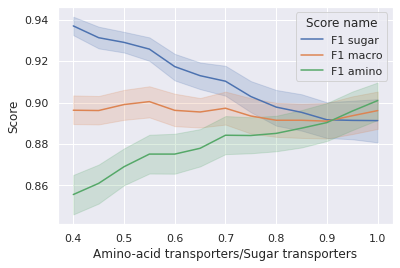

In [12]:
sns.set_theme()


def test_case(df_features, labels, freq_samples, random_seed, score):
    rus = RandomUnderSampler(random_state=random_seed, sampling_strategy=freq_samples)
    df_features_sampled, labels_sampled = rus.fit_resample(df_features, labels)

    # print(labels_sampled.value_counts())

    X = df_features_sampled.to_numpy()
    y = label_encoder.transform(labels_sampled)

    estimator = make_pipeline(StandardScaler(), SVC(class_weight="balanced"))

    cv_results = cross_val_score(estimator, X, y, n_jobs=1, scoring=score[1])
    records = []
    for cv_result in cv_results:
        records.append([score[0], freq_samples, cv_result])
    return records


df_aac_100 = calculate_aac(df.sequence)
labels = df.keywords_transport.rename("labels")
label_encoder = LabelEncoder()
label_encoder.fit(labels)

print(
    {
        label: enc
        for label, enc in zip(
            labels.unique(), label_encoder.transform(labels.unique()),
        )
    }
)
from sklearn.metrics import roc_auc_score, f1_score, make_scorer

records_list = Parallel(n_jobs=-1)(
    delayed(test_case)(df_aac_100, labels, freq_samples, random_seed, score)
    for freq_samples in [
        0.4,
        0.45,
        0.5,
        0.55,
        0.6,
        0.65,
        0.7,
        0.75,
        0.8,
        0.85,
        0.9,
        0.95,
        1.0,
    ]
    for random_seed in range(50)
    for score in [
        ("F1 sugar", make_scorer(f1_score, pos_label=1)),
        ("F1 macro", make_scorer(f1_score, average="macro")),
        ("F1 amino", make_scorer(f1_score, pos_label=0)),
    ]
)
records = []
for sl in records_list:
    for ssl in sl:
        records.append(ssl)
results_df = pd.DataFrame.from_records(
    records,
    columns=["Score name", "Amino-acid transporters/Sugar transporters", "Score"],
)
sns.set_theme()
# sns.set(font_scale=2)
g = sns.lineplot(
    data=results_df,
    x="Amino-acid transporters/Sugar transporters",
    y="Score",
    hue="Score name",
)

# plt.savefig("plots/athaliana_sugar_amino_cluster100_aac_downsampling.png", dpi=300)
